In [1]:
import pandas as pd
import os
import torch
from PIL import Image
import requests
import concurrent.futures as futures
import ast
import matplotlib.pyplot as plt
import io
import cv2
import matplotlib.patches as patches
import  os
import numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
root = '/content/drive/MyDrive/Dataset/'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!rm -r 'data'

rm: cannot remove 'data': No such file or directory


In [5]:
rootPth = 'data'
os.mkdir(rootPth)

#Creating sub-directories for training data
os.mkdir(rootPth +'/train')
os.mkdir(rootPth +'/train/images')
os.mkdir(rootPth +'/train/labels')

#Creating su-directories for testing data
os.mkdir(rootPth +'/test')
os.mkdir(rootPth +'/test/images')
os.mkdir(rootPth +'/test/labels')

In [6]:
import os

#To get the files that does not end with 'label.jpg'
#To separate original images and their respective masks
def get_filenames_without_label(directory):
  filenames = []
  for filename in os.listdir(directory):
    if not filename.endswith('label.jpg'):
      filenames.append(filename)
  return filenames

filenames = get_filenames_without_label(root)
filenames

['Image18.JPG',
 'Image20.JPG',
 'Image13.JPG',
 'Image19.JPG',
 'Image12.JPG',
 'Image14.JPG',
 'Image04.JPG',
 'Image07.JPG',
 'Image17.JPG',
 'Image05.JPG',
 'Image10.JPG',
 'Image11.JPG',
 'Image03.JPG',
 'Image15.JPG',
 'Image02.JPG',
 'Image06.JPG',
 'Image01.JPG',
 'Image08.JPG',
 'Image16.JPG',
 'Image09.JPG']

In [7]:
import numpy as np
import cv2
from shapely.geometry import Polygon

def mask_to_polygons(img_path, mask_path):

    #read the mask as grayscale
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(bool)
    #find contours in the mask image, to identify the co-ordinates of the masked stones
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)


    polygons = []
    normalized_polygons = []
    for contour in contours:


        try:
            polygon = contour.reshape(-1, 2).tolist()

            normalized_polygon = [[round(coord[0] / mask.shape[1] , 4), round(coord[1] / mask.shape[0] , 4)] for coord in polygon]
            #form a polygon using the co-ordinates of the masked stones
            polygon_shapely = Polygon(polygon)
            simplified_polygon = polygon_shapely.simplify(0.85, preserve_topology=True)
            polygons.append(simplified_polygon)

            normalized_polygons.append(Polygon(normalized_polygon))

        except Exception as e:
            pass
    return polygons, normalized_polygons

In [10]:
test_image = 'Image12'
poly, norm_poly = mask_to_polygons(root+f'/{test_image}.JPG', root+f'/{test_image}_label.jpg')

47


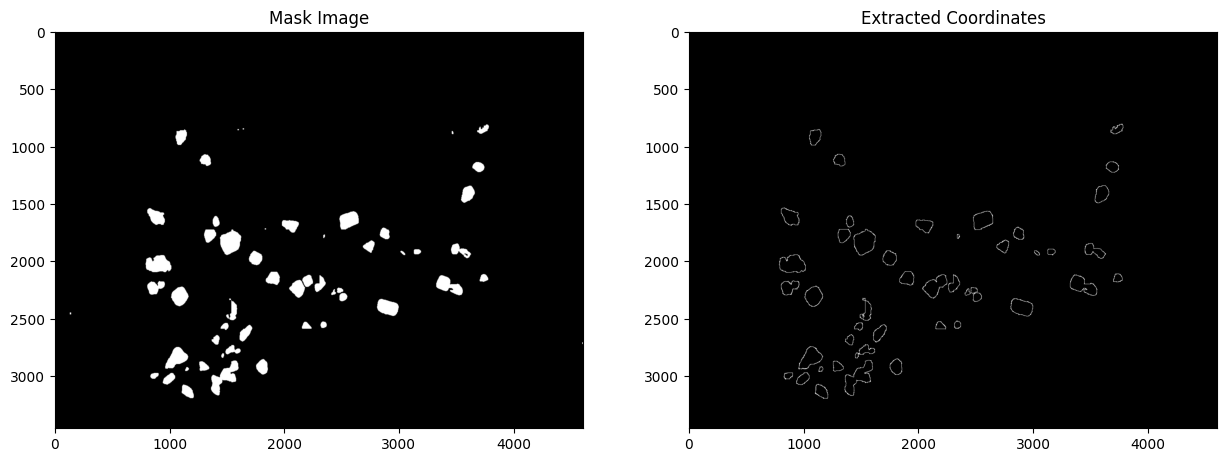

In [21]:
# Load the mask image and the original image
mask_image = cv2.imread(root+f'/{test_image}_label.jpg')
original_image = cv2.imread(root+f'/{test_image}.JPG')

# Create a black image to plot the polygons
black_image = np.zeros_like(original_image)

cnt = 0 # count of stones in the image
# Plot the polygons on the black image
for polygon in poly:
  x, y = polygon.exterior.xy
  if len(x) > 50:
    cnt += 1
    cv2.polylines(black_image, np.array([np.array(list(zip(x, y)))], dtype=np.int32), True, (255, 255, 255), 2)

print(cnt)

#Display the mask and the polygon of the mask
plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.imshow(mask_image)
plt.title('Mask Image')
plt.subplot(1, 2, 2)
plt.imshow(black_image)
plt.title('Extracted Coordinates')
plt.show()


In [12]:
def get_data(image_path, mask_path, flag = 'train'):
      try:
        image_file = 'data/{1}/images/{0}'.format(image_path, flag)
        image_txt  = 'data/{1}/labels/{0}.txt'.format(image_path.split('.JPG')[0], flag)

        image = Image.open(root+'/'+image_path)
        fp = open(image_txt,'w')
        poly, norm_poly = mask_to_polygons(root+'/'+image_path, root+'/'+mask_path)
        cnt = 0
        #extract the co-ordinates of the polygons and make them a numpy array, saves them as their text file for further training
        for polygon in norm_poly:
          poly_coor = '0 '
          x, y = polygon.exterior.xy
          x = np.array(x)
          y = np.array(y)
          if len(x) > 50:
            cnt += 1

            for iter in range(len(x)):

              poly_coor += str(x[iter])+' '
              poly_coor += str(y[iter])+' '

            poly_coor += '\n'
            fp.write(poly_coor)

        image.save(image_file)

        print(image_txt, cnt)

      except Exception as e:
        print(e)

In [13]:
for i in filenames[:18]:
  get_data(i ,i.replace('.JPG', '_label.jpg'))

data/train/labels/Image18.txt 55
data/train/labels/Image20.txt 47
data/train/labels/Image13.txt 49
data/train/labels/Image19.txt 49
data/train/labels/Image12.txt 51
data/train/labels/Image14.txt 52
data/train/labels/Image04.txt 10
data/train/labels/Image07.txt 66
data/train/labels/Image17.txt 53
data/train/labels/Image05.txt 12
data/train/labels/Image10.txt 48
data/train/labels/Image11.txt 46
data/train/labels/Image03.txt 22
data/train/labels/Image15.txt 52
data/train/labels/Image02.txt 7
data/train/labels/Image06.txt 49
data/train/labels/Image01.txt 21
data/train/labels/Image08.txt 50


In [14]:
for i in filenames[18:]:
  get_data(i ,i.replace('.JPG', '_label.jpg'), flag = 'test')

data/test/labels/Image16.txt 48
data/test/labels/Image09.txt 45


In [15]:
import os
#create a text file of valid image paths for further training
image_files = []
cnt = 0
for filename in os.listdir(rootPth +'/train/images/'):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png") or filename.endswith(".JPG"):
        image_txt  = rootPth +'/train/labels/{0}.txt'.format(str(filename.split('/')[-1]).split('.')[0])
        if os.path.exists(image_txt):
          image_files.append(rootPth +"/train/images/" + filename)
          cnt += 1

with open(rootPth + "/train/train.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()

In [17]:
print( len(os.listdir(rootPth +'/train/labels/')) )
print( len(os.listdir(rootPth +'/train/images/')) )

with open(rootPth +"/train/train.txt", 'r') as fp:
    x = len(fp.readlines())

18
18


In [18]:
import os
#create a text file of valid images of test data for further evaluation
image_files = []
cnt = 0
for filename in os.listdir(rootPth +'/test/images/'):
    if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png")  or filename.endswith(".JPG"):
        image_txt  = rootPth +'/test/labels/{0}.txt'.format(str(filename.split('/')[-1]).split('.')[0])
        if os.path.exists(image_txt):
          image_files.append(rootPth +"/test/images/" + filename)
          cnt += 1

with open(rootPth + "/test/test.txt", "w") as outfile:
    for image in image_files:
        outfile.write(image)
        outfile.write("\n")
    outfile.close()

In [19]:
print( len(os.listdir(rootPth +'/test/labels/')) )
print( len(os.listdir(rootPth +'/test/images/')) )

with open(rootPth +"/test/test.txt", 'r') as fp:
    x = len(fp.readlines())

2
2


In [20]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.3/721.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [22]:
from ultralytics import YOLO

model = YOLO("yolov8n-seg.pt")

100%|██████████| 6.73M/6.73M [00:00<00:00, 57.4MB/s]


In [23]:
model.train(data="/content/data.yaml", epochs= 100, imgsz=640)

Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=/content/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 16.5MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

train: Scanning /content/data/train/labels... 18 images, 0 backgrounds, 0 corrupt: 100%|██████████| 18/18 [00:00<00:00, 62.42it/s]

train: New cache created: /content/data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/data/test/labels... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<00:00, 54.73it/s]

val: New cache created: /content/data/test/labels.cache


Plotting labels to runs/segment/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0005), 76 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/segment/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.607      2.736      3.659      1.048         96        640: 100%|██████████| 2/2 [00:48<00:00, 24.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]

                   all          2         93     0.0133      0.086    0.00764    0.00432       0.02      0.129      0.012    0.00459



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.742      2.711      3.619     0.9858        124        640: 100%|██████████| 2/2 [00:40<00:00, 20.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.92s/it]

                   all          2         93      0.035      0.226     0.0246    0.00966       0.04      0.258     0.0297     0.0106



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.274      2.106      3.416     0.9089         71        640: 100%|██████████| 2/2 [00:30<00:00, 15.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93     0.0433       0.28     0.0447     0.0209       0.05      0.323     0.0534     0.0206



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.384      1.785      3.093     0.9097         52        640: 100%|██████████| 2/2 [00:28<00:00, 14.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.63s/it]

                   all          2         93     0.0467      0.301     0.0526      0.026     0.0583      0.376     0.0721     0.0277



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.649      2.223      2.793     0.9186        196        640: 100%|██████████| 2/2 [00:30<00:00, 15.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         93     0.0683      0.441      0.101     0.0459       0.08      0.516      0.118     0.0448



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.495      1.825      2.281     0.9045        141        640: 100%|██████████| 2/2 [00:30<00:00, 15.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          2         93     0.0717      0.462      0.106     0.0495     0.0967      0.624      0.145     0.0552



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G       1.52      1.941       1.63     0.9569         61        640: 100%|██████████| 2/2 [00:27<00:00, 13.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          2         93     0.0767      0.495       0.11     0.0488      0.095      0.613       0.19     0.0924



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.933      2.558      1.539     0.9328        208        640: 100%|██████████| 2/2 [00:30<00:00, 15.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.94s/it]

                   all          2         93     0.0783      0.505      0.115     0.0441      0.095      0.613      0.205     0.0872



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.451      1.806      1.191     0.8659        152        640: 100%|██████████| 2/2 [00:30<00:00, 15.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all          2         93     0.0767      0.495      0.127     0.0553     0.0967      0.624      0.225     0.0843



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.419      1.551       1.14     0.8933        140        640: 100%|██████████| 2/2 [00:29<00:00, 14.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.54s/it]

                   all          2         93     0.0817      0.527      0.182     0.0862       0.09      0.581      0.231     0.0921



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.425      1.964      1.114     0.8877        158        640: 100%|██████████| 2/2 [00:27<00:00, 13.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

                   all          2         93     0.0867      0.559      0.224      0.111     0.0967      0.624      0.237      0.103



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.335      1.787       1.15     0.8807        132        640: 100%|██████████| 2/2 [00:27<00:00, 13.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         93     0.0917      0.591      0.291      0.142     0.0967      0.624      0.285      0.133



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.405      1.826      1.315     0.8917         91        640: 100%|██████████| 2/2 [00:31<00:00, 15.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.095      0.613      0.258      0.136     0.0983      0.634       0.25      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.366      1.761      1.048     0.9027        166        640: 100%|██████████| 2/2 [00:31<00:00, 15.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.55s/it]

                   all          2         93     0.0983      0.634      0.237      0.132      0.102      0.656      0.226     0.0945



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.299      1.606      1.097     0.9088         67        640: 100%|██████████| 2/2 [00:28<00:00, 14.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93        0.1      0.645      0.241      0.143      0.102      0.656      0.225      0.097



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.205      1.614       1.01     0.8536        139        640: 100%|██████████| 2/2 [00:37<00:00, 18.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.99s/it]

                   all          2         93      0.102      0.656      0.251      0.144     0.0983      0.634      0.235      0.114



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.172      1.445     0.9238      0.875        121        640: 100%|██████████| 2/2 [00:33<00:00, 16.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.90s/it]

                   all          2         93      0.103      0.667      0.259      0.151     0.0967      0.624      0.249      0.121



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.169      1.611      1.078     0.9071         54        640: 100%|██████████| 2/2 [00:31<00:00, 15.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all          2         93      0.102      0.656      0.274      0.155      0.102      0.656       0.26      0.126



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G      1.316      1.654      1.027     0.8712        293        640: 100%|██████████| 2/2 [00:30<00:00, 15.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93        0.1      0.645      0.279      0.162     0.0983      0.634      0.263      0.127



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.186      1.623     0.9225     0.8753        115        640: 100%|██████████| 2/2 [00:27<00:00, 13.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          2         93     0.0983      0.634      0.273      0.164     0.0967      0.624      0.264      0.132



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.082      1.374     0.9069     0.8765         76        640: 100%|██████████| 2/2 [00:29<00:00, 14.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.16s/it]

                   all          2         93     0.0967      0.624      0.267      0.159     0.0933      0.602      0.271      0.134



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.162      1.404      0.876     0.8471        128        640: 100%|██████████| 2/2 [00:30<00:00, 15.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          2         93      0.095      0.613      0.284      0.167     0.0933      0.602      0.284      0.138



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.281      1.514     0.9111     0.8702        217        640: 100%|██████████| 2/2 [00:27<00:00, 13.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93      0.095      0.613      0.304      0.186     0.0917      0.591      0.301      0.137



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.245      1.574     0.8647     0.8546        122        640: 100%|██████████| 2/2 [00:27<00:00, 13.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93     0.0983      0.634      0.333      0.205     0.0983      0.634      0.329      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.166      1.634     0.8392     0.8731        115        640: 100%|██████████| 2/2 [00:34<00:00, 17.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          2         93     0.0983      0.634      0.372      0.215        0.1      0.645      0.372      0.199



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.148      1.395     0.8183     0.8706        140        640: 100%|██████████| 2/2 [00:32<00:00, 16.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93        0.1      0.645      0.394      0.225     0.0983      0.634      0.391      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.288       1.51     0.8604     0.8571        207        640: 100%|██████████| 2/2 [00:29<00:00, 14.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all          2         93      0.102      0.656      0.428      0.239     0.0967      0.624      0.402      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.162      1.548     0.8647     0.9131         68        640: 100%|██████████| 2/2 [00:29<00:00, 14.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93      0.102      0.656      0.428      0.239     0.0967      0.624      0.402      0.185



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      0.895      1.333     0.7466     0.8463         51        640: 100%|██████████| 2/2 [00:29<00:00, 14.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         93      0.103      0.667      0.482      0.282      0.103      0.667      0.445      0.201



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G      1.235      1.642     0.8659     0.8829        154        640: 100%|██████████| 2/2 [00:28<00:00, 14.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          2         93      0.102      0.656      0.483      0.271      0.103      0.667      0.471      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.101      1.315     0.7912     0.8674        135        640: 100%|██████████| 2/2 [00:29<00:00, 14.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

                   all          2         93      0.102      0.656      0.483      0.271      0.103      0.667      0.471      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.229      1.525     0.8315     0.8712        211        640: 100%|██████████| 2/2 [00:29<00:00, 14.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.105      0.677        0.5       0.28        0.1      0.645      0.442      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G      1.389       1.65     0.9131     0.8951        276        640: 100%|██████████| 2/2 [00:29<00:00, 14.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          2         93      0.105      0.677      0.481      0.275        0.1      0.645      0.446      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.104      1.481     0.8034     0.8752        141        640: 100%|██████████| 2/2 [00:27<00:00, 13.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93      0.105      0.677      0.481      0.275        0.1      0.645      0.446      0.196



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G       1.09      1.224     0.7505     0.8483        138        640: 100%|██████████| 2/2 [00:35<00:00, 17.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.57s/it]

                   all          2         93      0.752      0.409      0.508      0.291      0.131      0.602      0.507      0.229



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.431      1.725     0.8924     0.8916        323        640: 100%|██████████| 2/2 [00:30<00:00, 15.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93       0.78      0.409      0.525      0.325      0.863      0.407      0.539      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.226      1.417     0.8022     0.8664        160        640: 100%|██████████| 2/2 [00:28<00:00, 14.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          2         93       0.78      0.409      0.525      0.325      0.863      0.407      0.539      0.249



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.151      1.582      0.883     0.8903         96        640: 100%|██████████| 2/2 [00:30<00:00, 15.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.99s/it]

                   all          2         93       0.82      0.342      0.549      0.344      0.792      0.328      0.515       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.082      1.525     0.7511     0.8577         76        640: 100%|██████████| 2/2 [00:27<00:00, 13.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.64s/it]

                   all          2         93      0.782       0.27      0.521      0.312      0.782       0.27      0.481      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.158      1.375     0.8041     0.8696        161        640: 100%|██████████| 2/2 [00:34<00:00, 17.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.59s/it]

                   all          2         93      0.782       0.27      0.521      0.312      0.782       0.27      0.481      0.238



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.044      1.316     0.7197     0.8608        104        640: 100%|██████████| 2/2 [00:30<00:00, 15.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.26s/it]

                   all          2         93      0.826      0.356      0.552      0.332      0.845      0.353      0.518      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.171      1.409     0.7678     0.8637        218        640: 100%|██████████| 2/2 [00:28<00:00, 14.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.836      0.437      0.582      0.375      0.853      0.438       0.59      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G      1.074      1.228       1.99     0.9088         15        640: 100%|██████████| 2/2 [00:27<00:00, 13.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          2         93      0.836      0.437      0.582      0.375      0.853      0.438       0.59      0.253



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.8839      1.236     0.7577     0.8437         71        640: 100%|██████████| 2/2 [00:27<00:00, 13.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          2         93      0.896      0.376      0.583      0.363      0.922      0.384       0.57      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.097      1.394     0.8455     0.9184         73        640: 100%|██████████| 2/2 [00:27<00:00, 13.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          2         93      0.896      0.376      0.583      0.363      0.922      0.384       0.57      0.245



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.9373      1.002     0.7581     0.8388         33        640: 100%|██████████| 2/2 [00:30<00:00, 15.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.89s/it]

                   all          2         93      0.867      0.422      0.584       0.35      0.867      0.422      0.579      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.072      1.454     0.7559     0.8793        105        640: 100%|██████████| 2/2 [00:27<00:00, 13.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.01s/it]

                   all          2         93      0.867      0.422      0.584       0.35      0.867      0.422      0.579      0.251



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.194      1.501     0.8046     0.8682        109        640: 100%|██████████| 2/2 [00:28<00:00, 14.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          2         93       0.86      0.531      0.611      0.385      0.808      0.498      0.548      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.9946      1.347     0.7497     0.8596         60        640: 100%|██████████| 2/2 [00:29<00:00, 14.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93       0.86      0.531      0.611      0.385      0.808      0.498      0.548      0.239



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.045      1.306          1     0.8889         36        640: 100%|██████████| 2/2 [00:28<00:00, 14.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.77s/it]

                   all          2         93      0.839      0.516      0.607       0.38      0.752      0.462      0.532      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.9752        1.2     0.6884     0.8345         90        640: 100%|██████████| 2/2 [00:28<00:00, 14.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.81s/it]

                   all          2         93      0.839      0.516      0.607       0.38      0.752      0.462      0.532      0.217



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.099      1.335     0.8096     0.8534        206        640: 100%|██████████| 2/2 [00:27<00:00, 13.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          2         93      0.803      0.634      0.635      0.392      0.734      0.559      0.572      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.9786      1.135     0.7134     0.8661         92        640: 100%|██████████| 2/2 [00:26<00:00, 13.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93      0.803      0.634      0.635      0.392      0.734      0.559      0.572      0.225



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.059      1.223     0.7135      0.849        168        640: 100%|██████████| 2/2 [00:32<00:00, 16.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all          2         93      0.782      0.613      0.627      0.376      0.683      0.505       0.51      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.009      1.324     0.7362     0.8569         91        640: 100%|██████████| 2/2 [00:27<00:00, 13.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.58s/it]

                   all          2         93      0.782      0.613      0.627      0.376      0.683      0.505       0.51      0.205



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G      1.307      1.521     0.7942     0.8764        173        640: 100%|██████████| 2/2 [00:28<00:00, 14.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.48s/it]

                   all          2         93      0.757      0.604      0.625      0.378      0.697      0.494      0.513      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.9432      1.257     0.7102     0.8588         57        640: 100%|██████████| 2/2 [00:26<00:00, 13.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93      0.757      0.604      0.625      0.378      0.697      0.494      0.513      0.197



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.033      1.229     0.7591      0.844         76        640: 100%|██████████| 2/2 [00:30<00:00, 15.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          2         93      0.813      0.559      0.623      0.402      0.782      0.538       0.59      0.233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.026       1.29     0.6995     0.8428        152        640: 100%|██████████| 2/2 [00:28<00:00, 14.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.13s/it]

                   all          2         93      0.813      0.559      0.623      0.402      0.782      0.538       0.59      0.233



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.093      1.367     0.7849     0.8908         90        640: 100%|██████████| 2/2 [00:28<00:00, 14.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         93      0.812      0.559      0.616      0.419      0.812      0.559       0.63      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G     0.9138      1.245     0.6907     0.8659         76        640: 100%|██████████| 2/2 [00:27<00:00, 13.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93      0.812      0.559      0.616      0.419      0.812      0.559       0.63      0.274



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.003      1.162     0.7086     0.8659         88        640: 100%|██████████| 2/2 [00:28<00:00, 14.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          2         93      0.752       0.57      0.605      0.407      0.714      0.559      0.619      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.129      1.391     0.7386     0.8429        275        640: 100%|██████████| 2/2 [00:28<00:00, 14.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]

                   all          2         93      0.752       0.57      0.605      0.407      0.714      0.559      0.619      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.003      1.456     0.9329     0.8493         46        640: 100%|██████████| 2/2 [00:28<00:00, 14.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.774      0.591      0.644      0.417      0.756      0.581      0.627      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.9697       1.15      1.057     0.8489         52        640: 100%|██████████| 2/2 [00:26<00:00, 13.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.774      0.591      0.644      0.417      0.756      0.581      0.627      0.257



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.056      1.228     0.7198     0.8588        192        640: 100%|██████████| 2/2 [00:28<00:00, 14.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          2         93      0.856      0.581      0.654      0.401      0.836       0.57      0.628      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G       1.08      1.366     0.6583     0.8322        142        640: 100%|██████████| 2/2 [00:28<00:00, 14.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         93      0.856      0.581      0.654      0.401      0.836       0.57      0.628      0.291



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.142      1.443     0.7075     0.8451        124        640: 100%|██████████| 2/2 [00:27<00:00, 13.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]

                   all          2         93      0.815      0.602      0.669      0.407      0.723       0.57      0.573      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.015      1.231     0.6601     0.8533        100        640: 100%|██████████| 2/2 [00:29<00:00, 14.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

                   all          2         93      0.815      0.602      0.669      0.407      0.723       0.57      0.573      0.261



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.9749      1.188       0.74     0.8779         89        640: 100%|██████████| 2/2 [00:27<00:00, 13.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93      0.779      0.624      0.661       0.41      0.662      0.527       0.54       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.049      1.151     0.6924     0.8672         76        640: 100%|██████████| 2/2 [00:28<00:00, 14.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.779      0.624      0.661       0.41      0.662      0.527       0.54       0.24



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.037      1.343     0.7434     0.8679        115        640: 100%|██████████| 2/2 [00:28<00:00, 14.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         93      0.742      0.634      0.656      0.414      0.735      0.516      0.537       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.9731       1.19     0.7014     0.8636        102        640: 100%|██████████| 2/2 [00:29<00:00, 14.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.05s/it]

                   all          2         93      0.742      0.634      0.656      0.414      0.735      0.516      0.537       0.23



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.9724      1.337     0.7121     0.8598         97        640: 100%|██████████| 2/2 [00:30<00:00, 15.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          2         93      0.731      0.634       0.65      0.414      0.751      0.519      0.545      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.078      1.336     0.7324     0.8635        191        640: 100%|██████████| 2/2 [00:27<00:00, 13.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         93      0.731      0.634       0.65      0.414      0.751      0.519      0.545      0.235



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.9209      1.246     0.6643     0.8408        134        640: 100%|██████████| 2/2 [00:28<00:00, 14.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93      0.737      0.603      0.636      0.406      0.759      0.505      0.543      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G      1.075      1.431     0.7392     0.8505         93        640: 100%|██████████| 2/2 [00:28<00:00, 14.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.10s/it]

                   all          2         93      0.737      0.603      0.636      0.406      0.759      0.505      0.543      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.145      1.406     0.7293     0.8726        168        640: 100%|██████████| 2/2 [00:28<00:00, 14.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.20s/it]

                   all          2         93      0.676      0.602      0.592      0.379      0.671      0.452      0.491      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.9876      1.232     0.6876     0.8415         88        640: 100%|██████████| 2/2 [00:28<00:00, 14.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         93      0.676      0.602      0.592      0.379      0.671      0.452      0.491      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.019      1.277     0.7137     0.8353        197        640: 100%|██████████| 2/2 [00:28<00:00, 14.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          2         93      0.618      0.602      0.572      0.355       0.63       0.43      0.465      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.9898      1.363     0.6509     0.8273        192        640: 100%|██████████| 2/2 [00:27<00:00, 13.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.43s/it]

                   all          2         93      0.618      0.602      0.572      0.355       0.63       0.43      0.465      0.198



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.089      1.358     0.6766     0.8629        197        640: 100%|██████████| 2/2 [00:28<00:00, 14.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]

                   all          2         93      0.668       0.57      0.575      0.349      0.555      0.452      0.472      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G       1.07      1.463     0.7133     0.8926        152        640: 100%|██████████| 2/2 [00:28<00:00, 14.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.668       0.57      0.575      0.349      0.555      0.452      0.472      0.203



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.9921      1.167     0.6256     0.8307        139        640: 100%|██████████| 2/2 [00:27<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         93      0.655      0.591      0.598      0.378      0.706      0.495      0.538      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.182      1.328     0.7104      0.847        240        640: 100%|██████████| 2/2 [00:27<00:00, 13.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         93      0.655      0.591      0.598      0.378      0.706      0.495      0.538      0.228



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.004      1.213      0.681     0.8482        160        640: 100%|██████████| 2/2 [00:26<00:00, 13.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93      0.682      0.591      0.605      0.381      0.705      0.484      0.535      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.9952      1.317     0.6477     0.8572         75        640: 100%|██████████| 2/2 [00:29<00:00, 14.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:02<00:00,  2.18s/it]

                   all          2         93      0.682      0.591      0.605      0.381      0.705      0.484      0.535      0.232



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.8652      1.162     0.6546     0.8299         72        640: 100%|██████████| 2/2 [00:28<00:00, 14.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93       0.72      0.602      0.629      0.373      0.669      0.478      0.521      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.016      1.227     0.6663     0.8396        162        640: 100%|██████████| 2/2 [00:26<00:00, 13.42s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         93       0.72      0.602      0.629      0.373      0.669      0.478      0.521      0.219



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.031      1.318     0.6884      0.843        158        640: 100%|██████████| 2/2 [00:29<00:00, 14.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

                   all          2         93      0.752      0.587      0.634      0.367      0.685      0.469      0.513      0.211


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.8988      1.255     0.7343     0.8455        107        640: 100%|██████████| 2/2 [00:29<00:00, 14.65s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:03<00:00,  3.15s/it]

                   all          2         93      0.752      0.587      0.634      0.367      0.685      0.469      0.513      0.211



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G     0.8991       1.23     0.6638     0.8494         97        640: 100%|██████████| 2/2 [00:31<00:00, 15.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.78s/it]

                   all          2         93      0.769      0.624      0.653      0.385      0.728      0.473      0.533      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.051      1.501     0.6846     0.8884        106        640: 100%|██████████| 2/2 [00:25<00:00, 12.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.38s/it]

                   all          2         93      0.769      0.624      0.653      0.385      0.728      0.473      0.533      0.234



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      0.793     0.9326     0.6269     0.8164         29        640: 100%|██████████| 2/2 [00:28<00:00, 14.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.761      0.613      0.653        0.4       0.74       0.49      0.545      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.8931      1.208     0.6135     0.8441         66        640: 100%|██████████| 2/2 [00:26<00:00, 13.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.45s/it]

                   all          2         93      0.761      0.613      0.653        0.4       0.74       0.49      0.545      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.8517      1.014      0.707     0.8144         53        640: 100%|██████████| 2/2 [00:25<00:00, 12.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]

                   all          2         93      0.752      0.653      0.671      0.418       0.72       0.57      0.584       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G     0.8866      1.247     0.6683      0.849         94        640: 100%|██████████| 2/2 [00:26<00:00, 13.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.39s/it]

                   all          2         93      0.752      0.653      0.671      0.418       0.72       0.57      0.584       0.26



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.7924      1.042     0.6288     0.8421         56        640: 100%|██████████| 2/2 [00:25<00:00, 12.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.47s/it]

                   all          2         93      0.774      0.656      0.681      0.423      0.711      0.581        0.6      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.8229       1.02      1.139     0.8563         23        640: 100%|██████████| 2/2 [00:25<00:00, 12.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]

                   all          2         93      0.774      0.656      0.681      0.423      0.711      0.581        0.6      0.269



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.8221      1.188     0.6007     0.8206         70        640: 100%|██████████| 2/2 [00:25<00:00, 12.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.41s/it]

                   all          2         93      0.773      0.656      0.682      0.427       0.72      0.581      0.603      0.271



100 epochs completed in 0.876 hours.
Optimizer stripped from runs/segment/train/weights/last.pt, 6.8MB
Optimizer stripped from runs/segment/train/weights/best.pt, 6.8MB

Validating runs/segment/train/weights/best.pt...
Ultralytics YOLOv8.1.29 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients, 12.0 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


                   all          2         93      0.773      0.656      0.682      0.427       0.72      0.581      0.603       0.27
Speed: 2.1ms preprocess, 395.4ms inference, 0.0ms loss, 13.4ms postprocess per image
Results saved to runs/segment/train


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7df0c5c68670>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041, 

In [25]:
#load yolo model and the pre-trained weights
model = YOLO("/content/runs/segment/train/weights/best.pt")

In [26]:
#predict for the no. of stones in the test data
image = Image.open('/content/data/test/images/Image16.JPG')
results = model.predict(source=image, save=True)


0: 480x640 40 stoness, 304.3ms
Speed: 5.2ms preprocess, 304.3ms inference, 107.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict


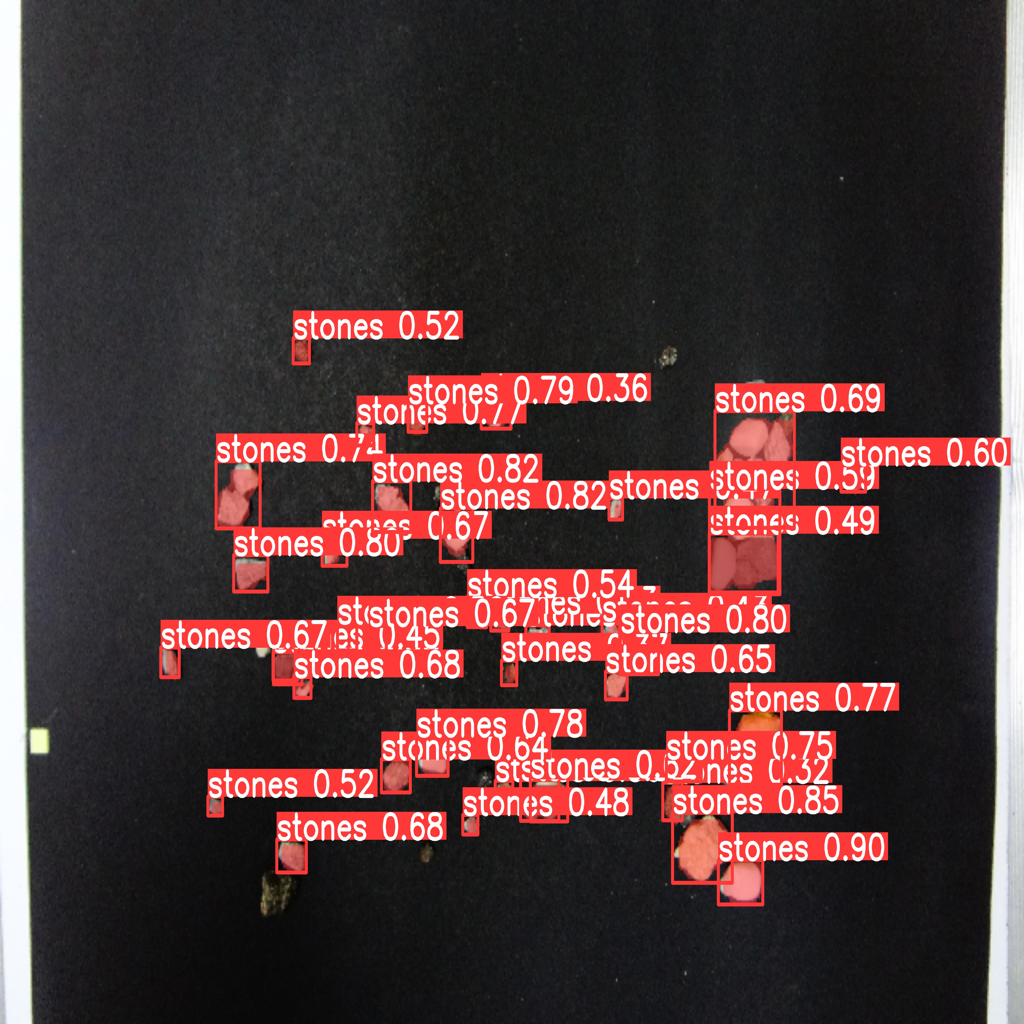

In [29]:
Image.open('runs/segment/predict/Image16.JPG').resize((1024, 1024))

In [31]:
image = Image.open('/content/data/test/images/Image09.JPG')
results = model.predict(source=image, save=True)


0: 480x640 36 stoness, 268.1ms
Speed: 5.9ms preprocess, 268.1ms inference, 97.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/segment/predict


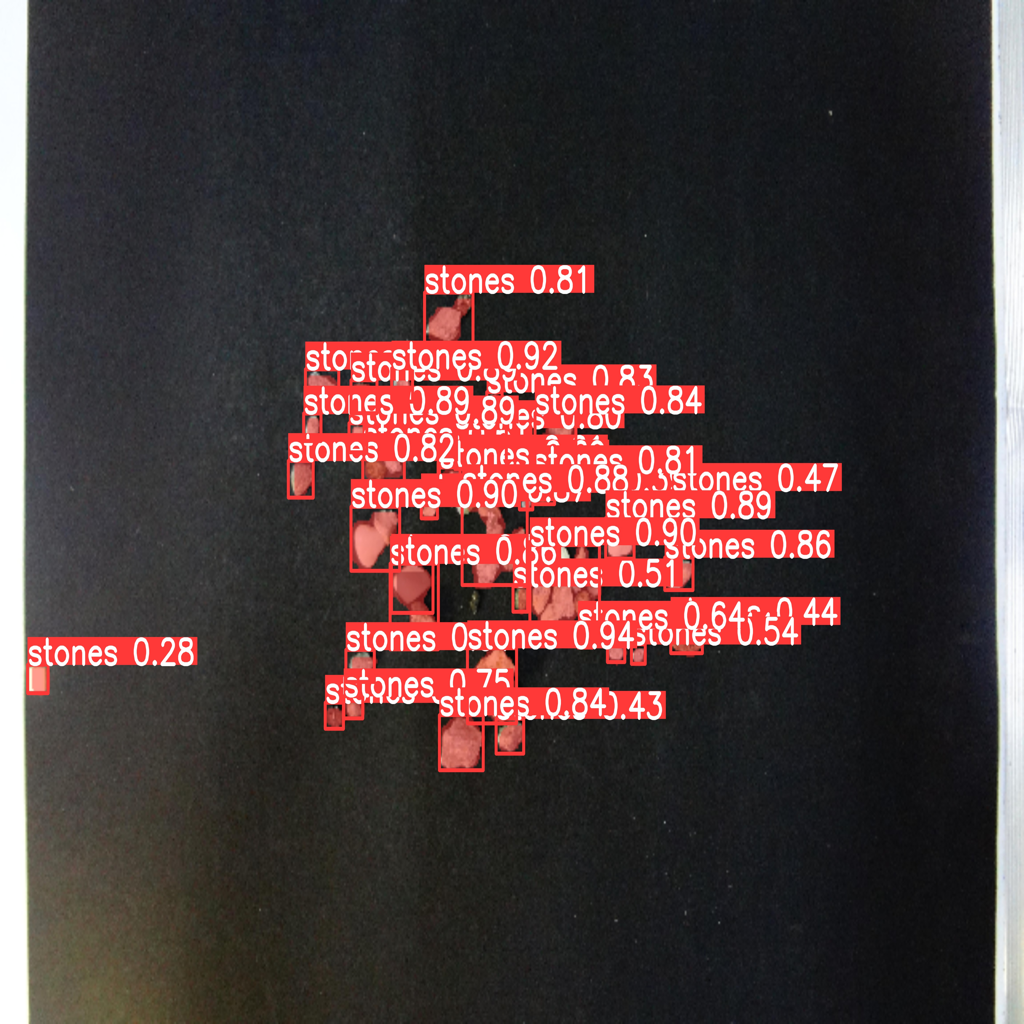

In [32]:
Image.open('runs/segment/predict/Image09.JPG').resize((1024, 1024))